###  Setup: import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [5]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

In [6]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(in_features=28*28, out_features = 256)
    self.fc2 = nn.Linear(in_features=256, out_features = 10)
    self.layers = [self.fc1, self.fc2]

  # define forward function
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    t = t.reshape(-1, 28*28)
    t = self.fc1(t)
    self.z.append(t)
    t = F.relu(t)
    t = self.fc2(t)
    self.z.append(t)
    return t

In [7]:
def train(net, criterion, trainloader, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

In [8]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, 0.01)

Epoch 0 Iter: 0 Loss 2.3537709712982178
Epoch 0 Iter: 500 Loss 0.3004954159259796
Epoch 0 Iter: 1000 Loss 0.6654969453811646
Epoch 0 Iter: 1500 Loss 0.07038380205631256
Epoch 0 Iter: 2000 Loss 0.48078298568725586
Epoch 0 Iter: 2500 Loss 1.1761261224746704
Epoch 0 Iter: 3000 Loss 0.12577514350414276
Epoch 0 Iter: 3500 Loss 0.7743905782699585
Epoch 0 Iter: 4000 Loss 0.5979464650154114
Epoch 0 Iter: 4500 Loss 0.3555711507797241
Epoch 0 Iter: 5000 Loss 1.7088162899017334
Epoch 0 Iter: 5500 Loss 0.8804323673248291
Epoch 0 Iter: 6000 Loss 0.6518594622612
Epoch 0 Iter: 6500 Loss 0.564293622970581
Epoch 0 Iter: 7000 Loss 1.0113842487335205
Epoch 0 Iter: 7500 Loss 1.6366491317749023
Epoch 0 Iter: 8000 Loss 0.11564537137746811
Epoch 0 Iter: 8500 Loss 0.22191423177719116
Epoch 0 Iter: 9000 Loss 0.7717753648757935
Epoch 0 Iter: 9500 Loss 2.5789377689361572
Epoch 0 Iter: 10000 Loss 0.10187274217605591
Epoch 0 Iter: 10500 Loss 0.2916305661201477
Epoch 0 Iter: 11000 Loss 0.009975656867027283
Epoch 0 

In [9]:
torch.save(net.state_dict(),"original_params.pth")

In [40]:
def apply_transform(image, angle, translate, scale=1.0):
    if image.dim() != 4:
        image = image.unsqueeze(0)
        assert(0)

    transform = transforms.Compose([
        transforms.RandomAffine(degrees=(-angle, angle), translate=(translate, translate), scale=(scale, scale))
    ])
    return transform(image)



In [41]:
def evaluate_attack(model, device, data_loader, angle, translate):
    model.eval()
    correct = 0
    total = 0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        perturbed_data = apply_transform(data, angle, translate)
        outputs = model(perturbed_data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    error = 1-correct/total
    print(f'Accuracy : {100 * correct / total:.2f}%, Angle={angle}, Translation={translate:.2f}',error)
    return error



In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
model.load_state_dict(torch.load('eps0.05_params.pth'))  
test_loader = testloader

def run_evaluation(model, device, test_loader):
    errors = []
    angles = np.arange(1, 31, 2) 
    translations = np.arange(0.01, 0.11, 0.02)  

    for angle in angles:
        for translate in translations:
            #print(angle)
            #prinf(translate)
            error = evaluate_attack(model, device, test_loader, angle, translate)
            errors.append((angle, translate, error))
            #print(error)
            
    return errors

errors = run_evaluation(model, device, test_loader)


Accuracy : 95.36%, Angle=1, Translation=0.01 0.0464
Accuracy : 92.24%, Angle=1, Translation=0.03 0.0776
Accuracy : 89.74%, Angle=1, Translation=0.05 0.10260000000000002
Accuracy : 81.02%, Angle=1, Translation=0.07 0.18979999999999997
Accuracy : 71.53%, Angle=1, Translation=0.09 0.28469999999999995
Accuracy : 95.38%, Angle=3, Translation=0.01 0.04620000000000002
Accuracy : 92.08%, Angle=3, Translation=0.03 0.07920000000000005
Accuracy : 89.79%, Angle=3, Translation=0.05 0.10209999999999997
Accuracy : 79.68%, Angle=3, Translation=0.07 0.20320000000000005
Accuracy : 72.11%, Angle=3, Translation=0.09 0.27890000000000004
Accuracy : 95.21%, Angle=5, Translation=0.01 0.047900000000000054
Accuracy : 92.06%, Angle=5, Translation=0.03 0.07940000000000003
Accuracy : 89.82%, Angle=5, Translation=0.05 0.1018
Accuracy : 80.20%, Angle=5, Translation=0.07 0.19799999999999995
Accuracy : 72.03%, Angle=5, Translation=0.09 0.27969999999999995
Accuracy : 94.88%, Angle=7, Translation=0.01 0.0512000000000000

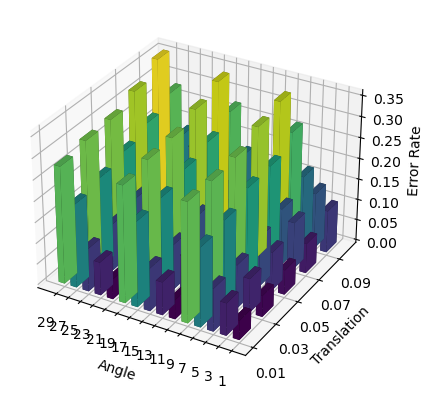

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot_errors(errors):
    
    angles, translations, error_rates = zip(*errors)

    angle_unique = np.unique(angles)
    translate_unique = np.unique(translations)
    X, Y = np.meshgrid(angle_unique, translate_unique)
    

    Z = np.array(error_rates).reshape(len(translate_unique), len(angle_unique))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))

    for i in range(len(translate_unique)):
        for j in range(len(angle_unique)):
            ax.bar3d(X[i, j], Y[i, j], 0, 1, 0.01, Z[i, j], color=colors[i, j], zsort='average')

    ax.set_xlabel('Angle')
    ax.set_ylabel('Translation')
    ax.set_zlabel('Error Rate')

    ax.set_xticks(angle_unique)
    ax.set_yticks(np.round(translate_unique, 2))

    ax.invert_xaxis()

    plt.show()

plot_errors(errors)



In [56]:
original_model = Net().to(device)
original_model.load_state_dict(torch.load('original_params.pth'))
eps_005 = Net().to(device)
eps_005.load_state_dict(torch.load('eps0.05_params.pth'))
eps_02 = Net().to(device)
eps_02.load_state_dict(torch.load('eps0.2_params.pth'))
a = 9
t = 0.05
networks_err = []
networks_err.append((evaluate_attack(original_model,device,test_loader,a,t),"original"))
networks_err.append((evaluate_attack(eps_005,device,test_loader,a,t),"epsilon=0.05"))
networks_err.append((evaluate_attack(eps_02,device,test_loader,a,t),"epsilon=0.2"))


Accuracy : 75.69%, Angle=9, Translation=0.05 0.24309999999999998
Accuracy : 89.07%, Angle=9, Translation=0.05 0.10929999999999995
Accuracy : 70.93%, Angle=9, Translation=0.05 0.29069999999999996


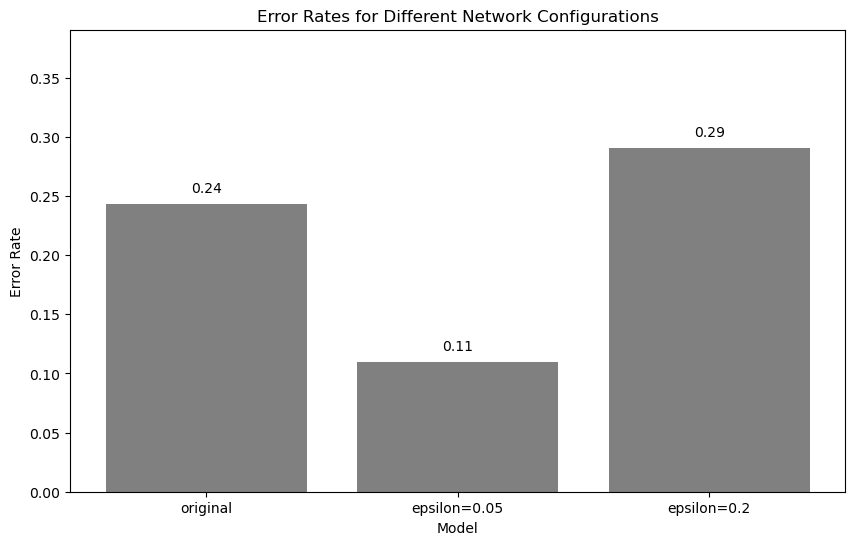

In [57]:
def plot_network_errors(errors, labels):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, errors, color='grey')

    plt.xlabel('Model')
    plt.ylabel('Error Rate')
    plt.title('Error Rates for Different Network Configurations')


    for i, error in enumerate(errors):
        plt.text(i, error + 0.01, f'{error:.2f}', ha='center')

    plt.ylim(0, max(errors) + 0.1)  
    plt.show()

errors = [item[0] for item in networks_err]
labels = [item[1] for item in networks_err]
plot_network_errors(errors, labels)

